In [1]:
import os
import sys
import cv2
import numpy as np
import scipy.signal as si
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
%cd 'drive/My Drive'
%cd 'Colab Notebooks/RaiSceneDetection'

/content/drive/My Drive
/content/drive/My Drive/Colab Notebooks/RaiSceneDetection


In [4]:
# returns the edge-change-ratio
# The crop parameter can help you to reduce noises (e.g. subtitiles),
# the dilate_rate parameter controls the distance of the pixels between the frame
# and prev_frame
def ECR(frame, prev_frame, width, height, crop=True, dilate_rate = 5):
    safe_div = lambda x,y: 0 if y == 0 else x / y
    if crop:
        startY = int(height * 0.3)
        endY = int(height * 0.8)
        startX = int(width * 0.3)
        endX = int(width * 0.8)
        frame = frame[startY:endY, startX:endX]
        prev_frame = prev_frame[startY:endY, startX:endX]

    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edge = cv2.Canny(gray_image, 0, 200)
    dilated = cv2.dilate(edge, np.ones((dilate_rate, dilate_rate)))
    inverted = (255 - dilated)
    gray_image2 = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    edge2 = cv2.Canny(gray_image2, 0, 200)
    dilated2 = cv2.dilate(edge2, np.ones((dilate_rate, dilate_rate)))
    inverted2 = (255 - dilated2)
    log_and1 = (edge2 & inverted)
    log_and2 = (edge & inverted2)
    pixels_sum_new = np.sum(edge)
    pixels_sum_old = np.sum(edge2)
    out_pixels = np.sum(log_and1)
    in_pixels = np.sum(log_and2)
    return max(safe_div(float(in_pixels),float(pixels_sum_new)), safe_div(float(out_pixels),float(pixels_sum_old)))

In [5]:
def video2frame(video_src_path, formats, file_save_path):
    """
    detect the shot boundary of the first and last frame
    :param video_src_path:  video file to detect
    :param formats: video formats to detect
    :param file_save_path: frames saved location
    :return: frame and index
    """

    f = open(file_save_path, 'w')
    diff_threshold = 0.65
    window_size = 10

    if os.path.isfile(video_src_path):
        video = video_src_path.split('/')[-1]
    else:
        raise SystemExit('wrong path')

    if video[-4:] not in formats:
        raise SystemExit('wrong format')


    # open a video
    cap = cv2.VideoCapture(video_src_path)

    frame_num = cap.get(7)
    width = cap.get(3)
    height = cap.get(4)
    cap.set(3, width)
    cap.set(4, height)
    prev_frame = None


    print('Numbers of frames: ', int(frame_num - 1))
    ecr_diff = []
    frame_index = []
    ecr_diff.append(0)

    if cap.isOpened():
        success = True
    else:
        success = False
        print("Fail in reading videos!")

    frame_count = 0

    # read a frame
    while success:
        read, frame = cap.read()
        #print(frame_count, read)

        if read:
          if frame is None:
            break
          if prev_frame is not None:
            ecr = ECR(frame, prev_frame, width, height)
            ecr_diff.append(ecr)
          frame_index.append(frame_count)
          prev_frame = frame

          frame_count += 1

        else:
            break


    vector = np.array(ecr_diff)
    print(vector)
    indexes, _ = si.find_peaks(vector, height=diff_threshold, distance=window_size)

    print('Numbers of shots', len(indexes))

    # write down the shot boundary frames' index
    f.write("0"+"\t")
    for index in indexes:
        f.write(str(index-1)+"\n"+str(index)+"\t")

    f.write(str(int(frame_num - 1)))
    # close the video
    cap.release()

    # show the frames' histogram differences
    plt.figure(figsize=(15,15))
    plt.plot(frame_index, ecr_diff)
    plt.xlabel("frame")
    plt.ylabel("ecr difference with previous one")
    plt.show()

23553
Numbers of frames:  14540
[0.         0.26069293 0.22972559 ... 0.00432526 0.01124567 0.00790861]
Numbers of shots 107


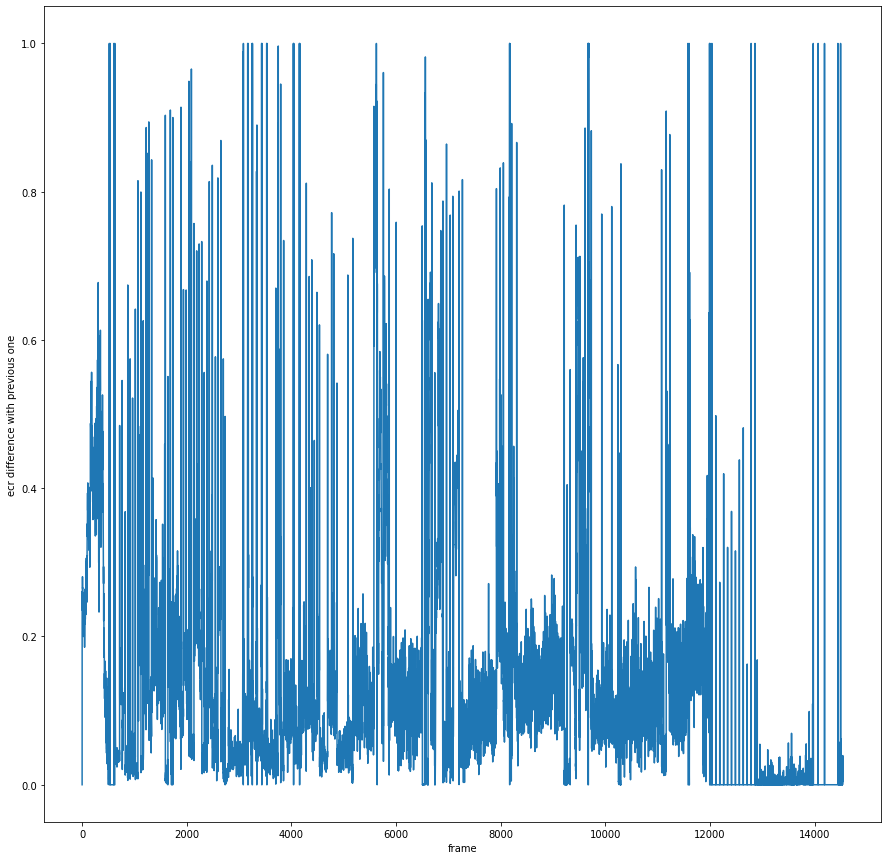

25012
Numbers of frames:  14999
[0.         0.         0.         ... 0.15676516 0.11839892 0.10814419]
Numbers of shots 79


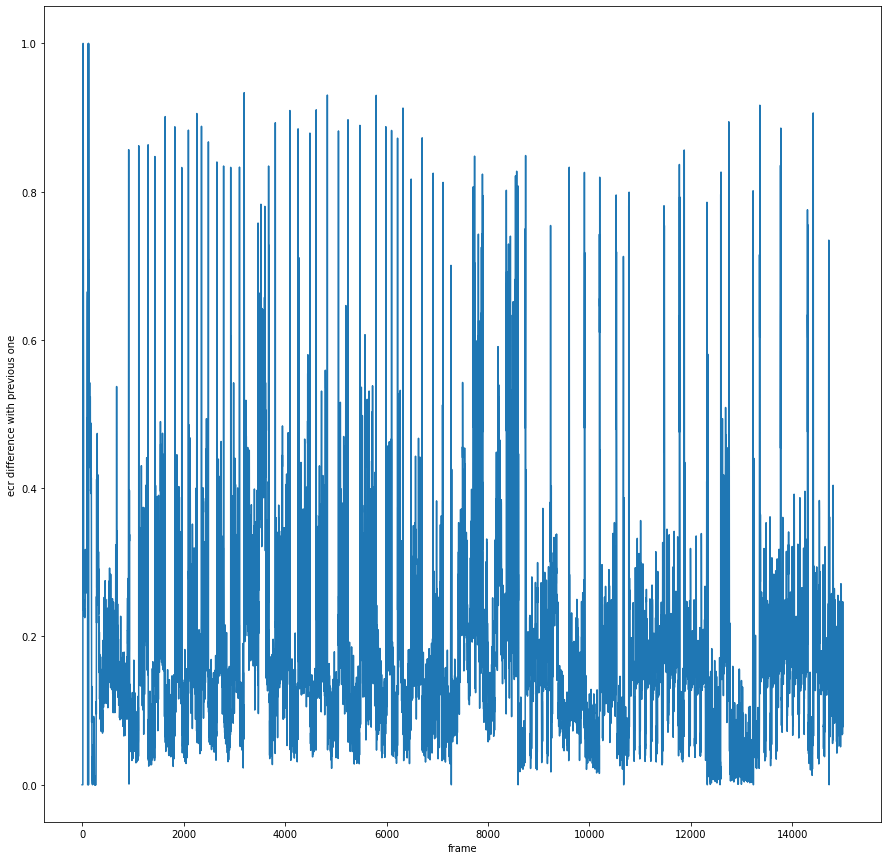

21829
Numbers of frames:  14774
[0.         0.0063358  0.         ... 0.056      0.02727273 0.        ]
Numbers of shots 186


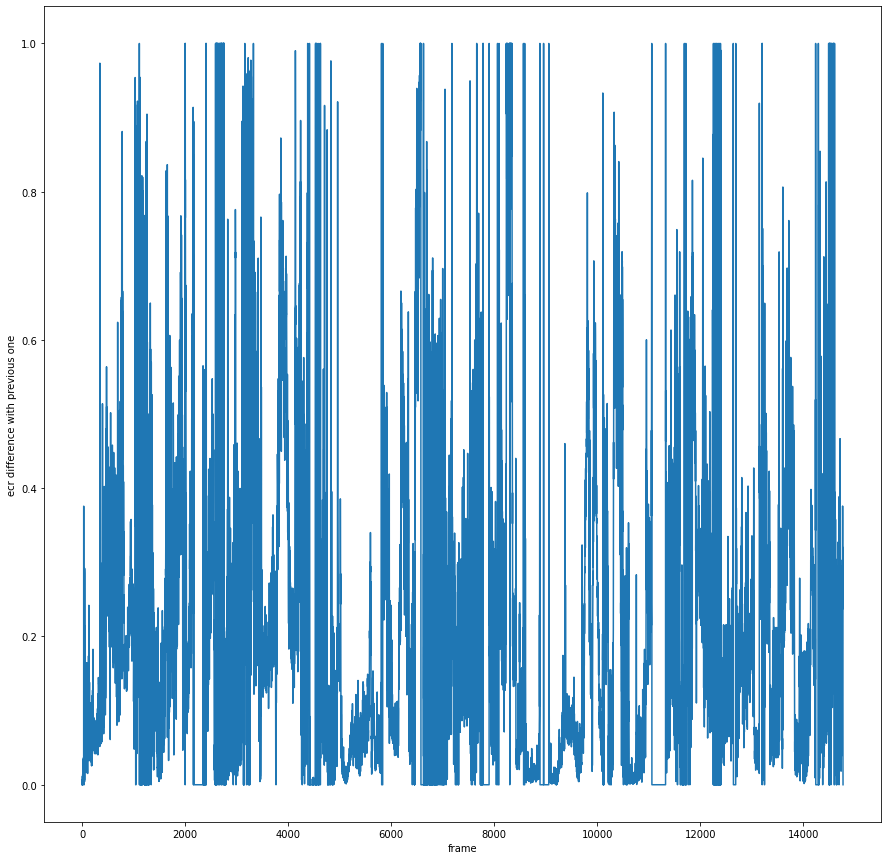

23557
Numbers of frames:  14282
[0.         0.37569061 0.64507422 ... 0.         0.05479452 0.        ]
Numbers of shots 63


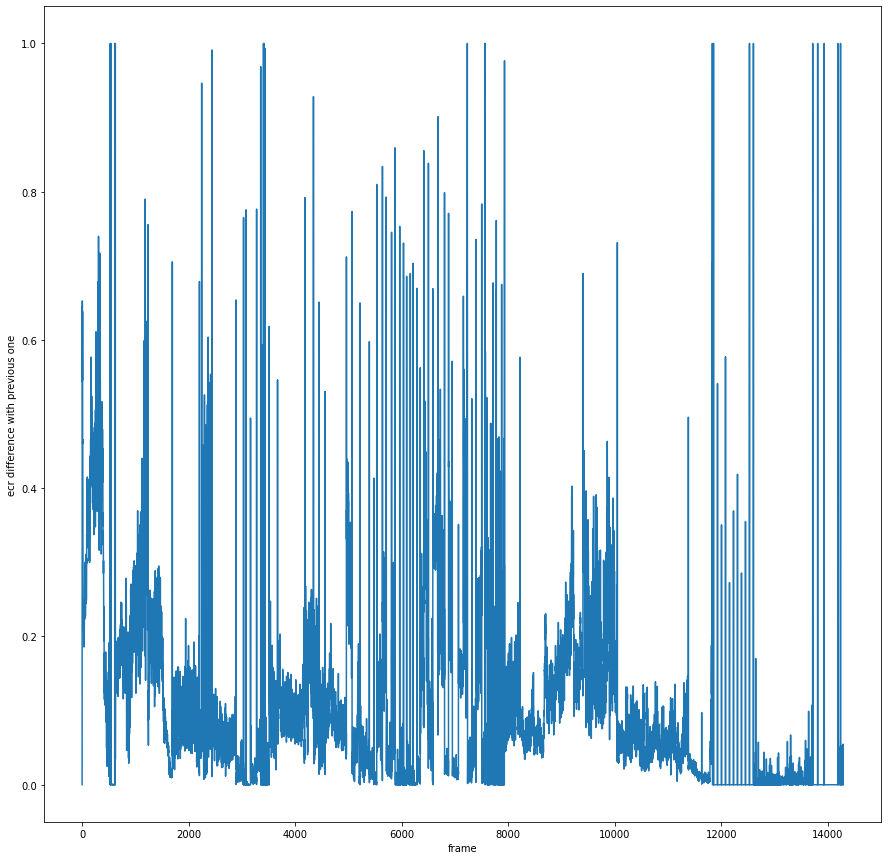

21867
Numbers of frames:  14759
[0.         0.04097819 0.01894452 ... 0.08367451 0.1166752  0.0060925 ]
Numbers of shots 167


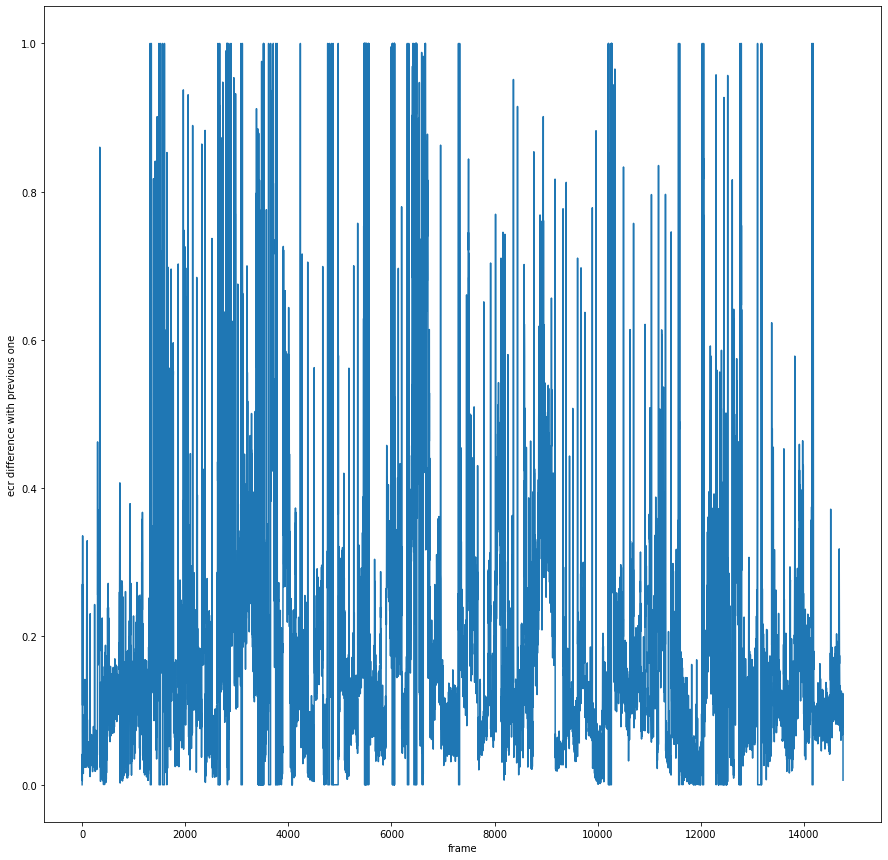

23558
Numbers of frames:  14265
[0.         0.24985655 0.24214649 ... 0.         0.         0.        ]
Numbers of shots 127


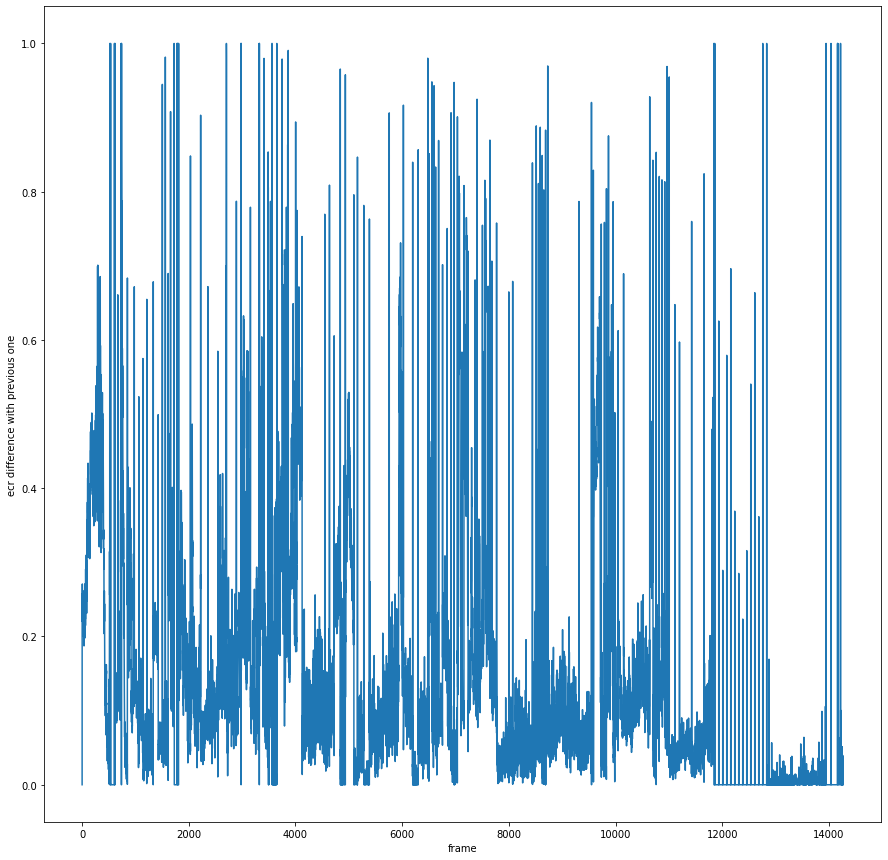

25008
Numbers of frames:  14999
[0.         0.         0.         ... 0.31522271 0.26350139 0.35446906]
Numbers of shots 215


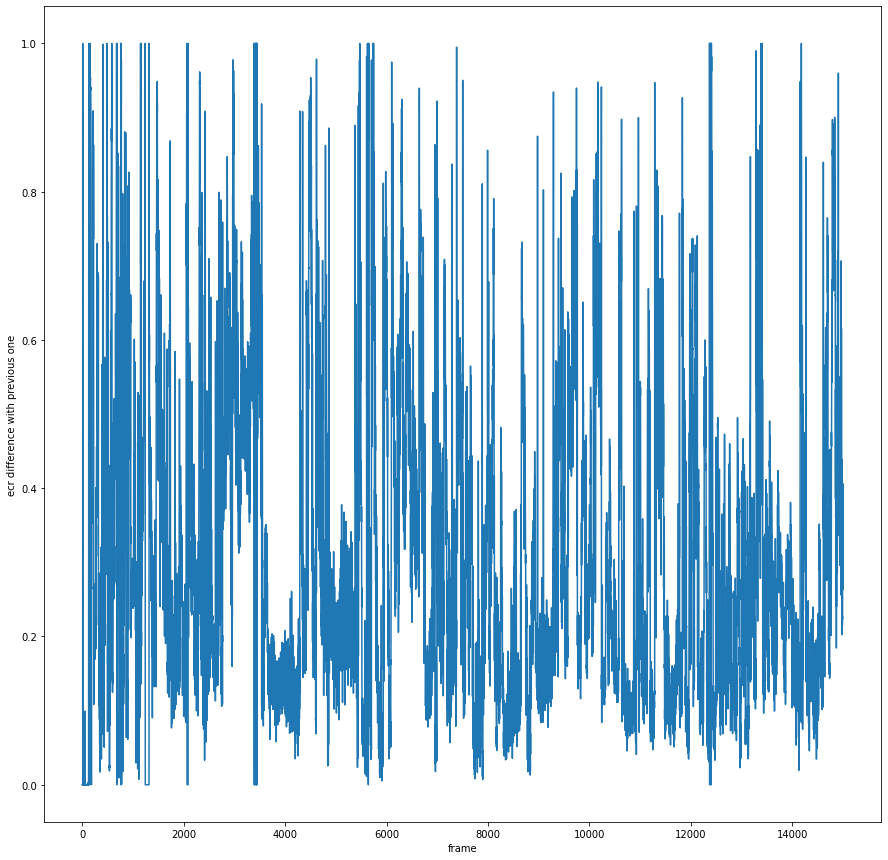

25009
Numbers of frames:  14999
[0.         0.90172272 0.16099281 ... 0.14589117 0.18892282 0.17001568]
Numbers of shots 291


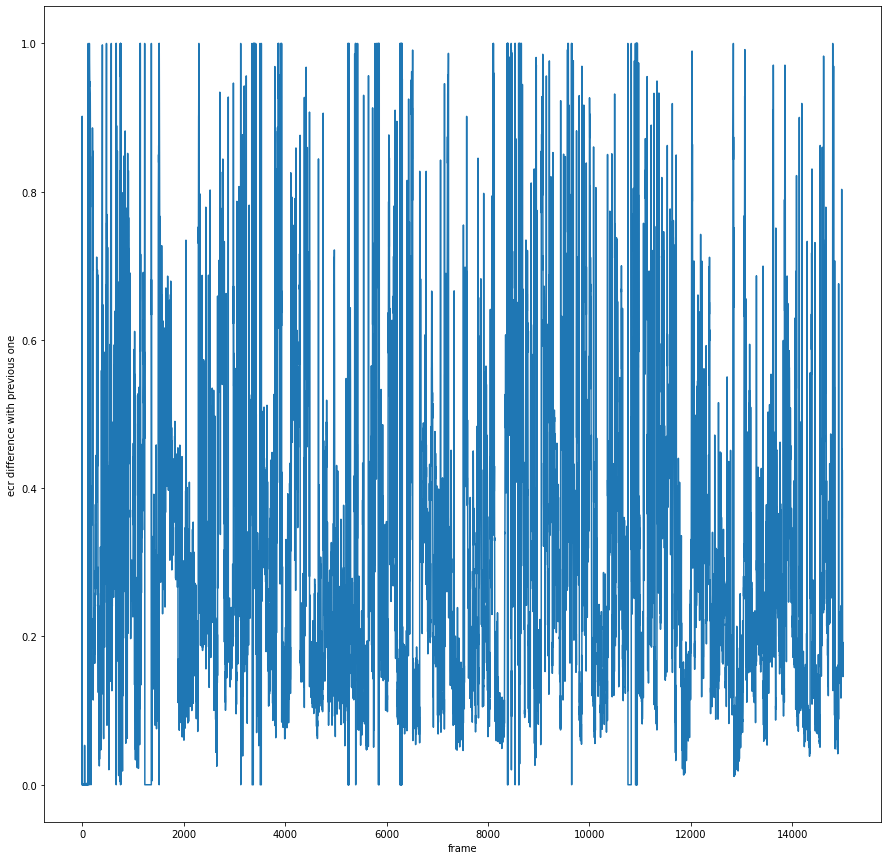

25010
Numbers of frames:  14999
[0.         0.         0.         ... 0.10626703 0.08841099 0.08159057]
Numbers of shots 241


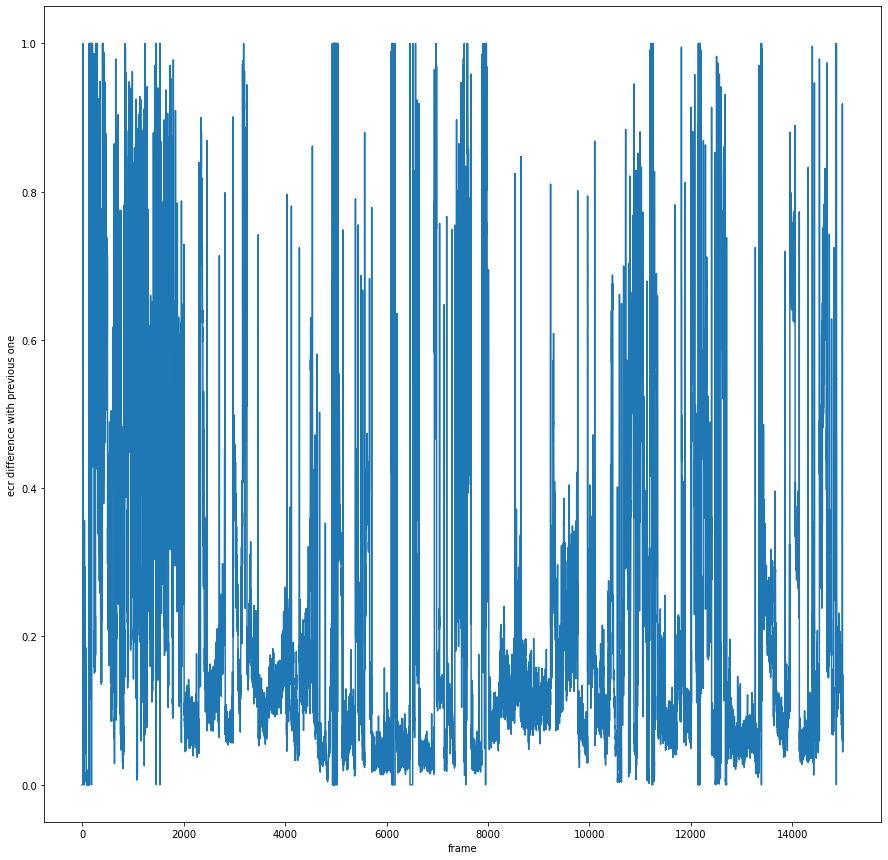

25011
Numbers of frames:  14999
[0.         0.         0.         ... 0.59724876 0.63438993 0.63720074]
Numbers of shots 63


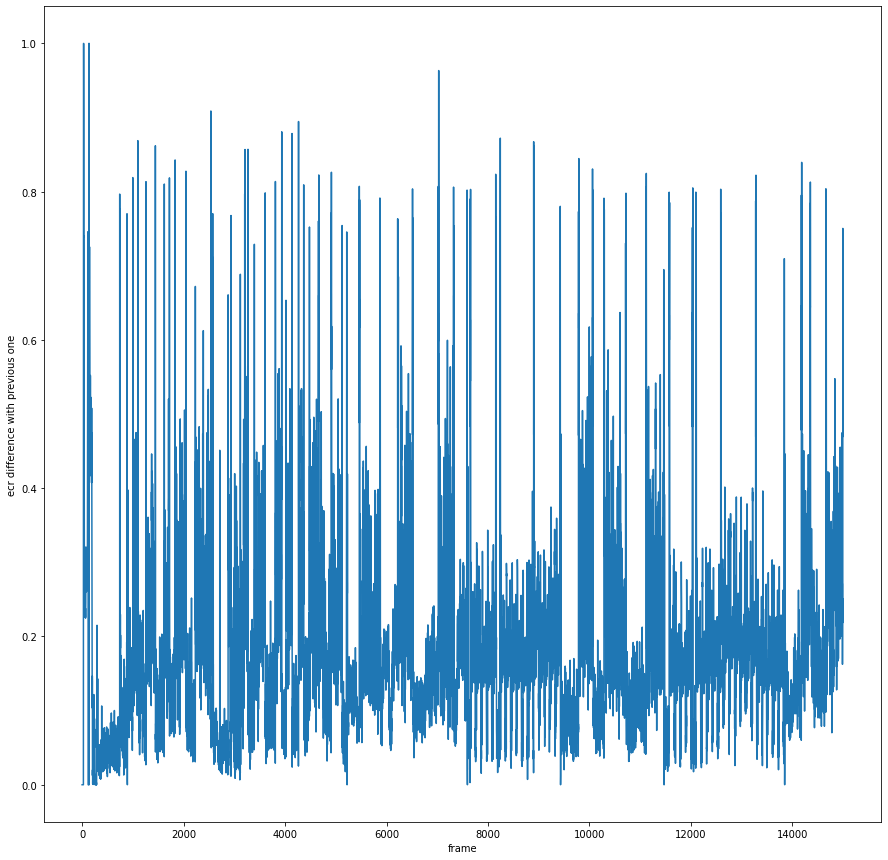

In [6]:
from pathlib import Path

video_formats = [".MP4", ".mp4"]

for file in os.listdir("./RAIDataset"):
    if (file.endswith(".MP4")|file.endswith(".mp4")):
        videos_src_path = os.path.join("./RAIDataset", file)
        file_name = Path(videos_src_path).stem
        print(file_name)
        save_file = "".join([file_name,"_result.txt"])
        files_save_path = os.path.join("ECR", save_file)
        video2frame(videos_src_path, video_formats, files_save_path)